In [52]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings('ignore', message="The sklearn.metrics.classification module", category=FutureWarning)
warnings.filterwarnings('ignore', message=".*title_format is deprecated. Please use title instead.*")
warnings.filterwarnings('ignore', message="optional dependency `torch` is not available. - skipping import of NN models.")
warnings.filterwarnings('ignore', message="The default value of regex will change from True to False in a future version.", 
                        category=FutureWarning)

import os
import os.path as op
import shutil
import bokeh

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime

from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
import sys
import panel as pn
pn.extension('bokeh')

bokeh extension not recognized and will be skipped.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
#standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning, initialize_environment,
    get_package_path, display_as_tabs, save_data, save_pipeline, load_dataframe, load_pipeline, load_dataset, DEFAULT_ARTIFACTS_PATH
)
import ta_lib.core.api as dataset
import ta_lib.eda.api as ta_analysis
from ta_lib.reports.api import create_report
import ta_lib.reports.api as health
from sklearn.ensemble import RandomForestClassifier
from ta_lib.classification.api import ClassificationComparison, ClassificationReport, confusion_matrix_by_feature, SKLStatsmodelLogit
from ta_lib.data_processing.api import Outlier, WoeBinningTransformer

#from scripts import * 

os.environ['TA_DEBUG'] = "False"
os.environ['TA_ALLOW_EXCEPTIONS'] = "True"

# Initialization
initialize_environment(debug=False, hide_warnings=True)

In [54]:
%matplotlib inline

In [66]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
print(dataset.list_datasets(context))

['/raw/opportunity', '/raw/product', '/cleaned/opportunity', '/cleaned/product', '/processed/merged_final_dataset', '/train/features', '/train/target', '/test/features', '/test/target']


In [67]:
data = dataset.load_dataset(context,'/processed/merged_final_dataset')
data.head()

,Unnamed: 0,opportunity id,transition to stage,transition to timestamp,transition from stage name,transition from timestamp,customer name,risk status,creation date,decision date,...,core sales segment,geography,core product application,time taken for transition,product id,product status,product $,product quantity,snapshot time,cost_per_unit
0,2,5,3,2015-03-04 21:00:02,3,2015-03-04 21:00:02,83,0,11-02-2015,12-03-2015,...,8,-1,4,0.0,404,1,230400.0,1200.0,2015-02-11 21:00:01,192.0
1,3,5,4,2015-03-16 13:00:01,3,2015-03-04 21:00:02,83,0,11-02-2015,12-03-2015,...,8,-1,4,11919999.0,404,1,230400.0,1200.0,2015-02-11 21:00:01,192.0
2,4,5,4,2015-03-17 13:00:01,4,2015-03-16 13:00:01,83,0,11-02-2015,12-03-2015,...,8,1,4,1000000.0,404,1,230400.0,1200.0,2015-02-11 21:00:01,192.0
3,5,5,4,2015-03-23 21:00:01,4,2015-03-17 13:00:01,83,0,11-02-2015,12-03-2015,...,8,3,4,6080000.0,404,1,230400.0,1200.0,2015-02-11 21:00:01,192.0
4,6,5,4,2015-08-10 18:37:57,4,2015-07-18 05:00:03,83,0,11-02-2015,12-03-2015,...,8,3,4,92133754.0,404,1,230400.0,1200.0,2015-02-11 21:00:01,192.0


In [68]:
data.drop(['Unnamed: 0'], axis =1, inplace = True)

<AxesSubplot:xlabel='opportunity id', ylabel='transition to timestamp'>

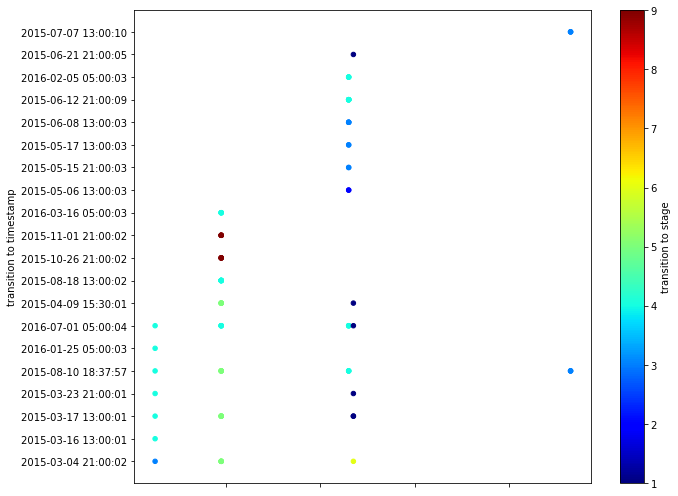

In [71]:
data.iloc[:100].plot(kind="scatter", x='opportunity id', y="transition to timestamp",
figsize=(10,7),c="transition to stage",cmap=plt.get_cmap("jet"), colorbar=True)


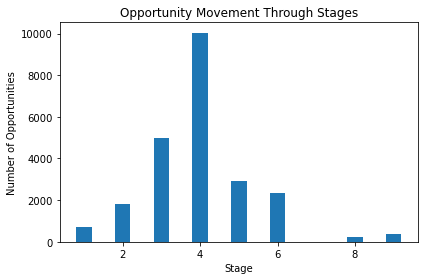

In [72]:
stages = data['transition to stage'].unique()
stages.sort()
stage_counts = data['transition to stage'].value_counts().sort_index()

# Create line chart
plt.bar(stages, stage_counts, width=0.4)
plt.xlabel('Stage')
plt.ylabel('Number of Opportunities')
plt.title('Opportunity Movement Through Stages')

# Show chart
plt.show()

<AxesSubplot:xlabel='opportunity id', ylabel='transition to stage'>

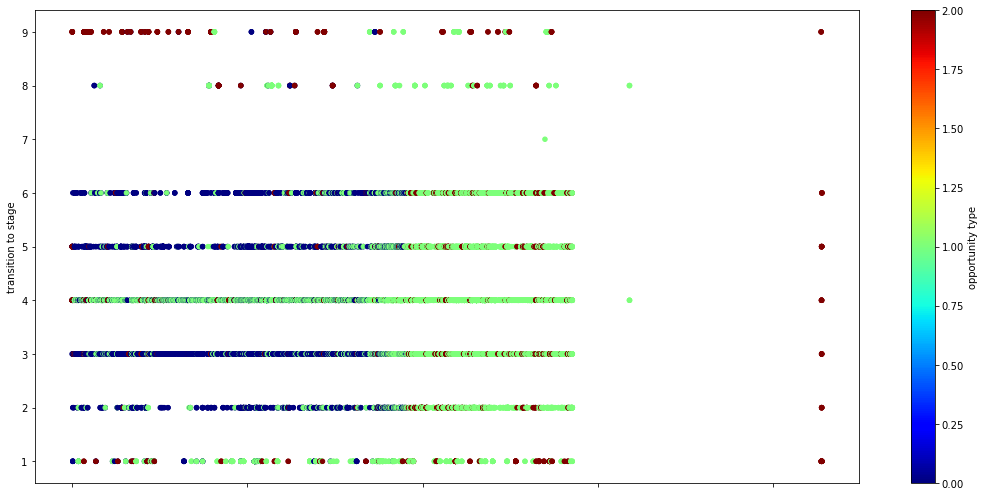

In [73]:
data.plot(kind="scatter", c="opportunity type", y="transition to stage",figsize=(15,7),
       x="opportunity id", cmap=plt.get_cmap("jet"), colorbar=True)

Text(0, 0.5, 'Mean Transition Time in Seconds')

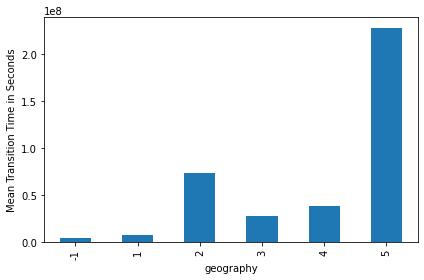

In [74]:
data['time taken for transition'].fillna(data['time taken for transition'].median(), inplace = True)
df = data.groupby('geography')['time taken for transition'].mean()
ax = df.plot.bar()
ax.set_ylabel("Mean Transition Time in Seconds")

In [75]:
df = data
stats.f_oneway(df[df['geography'] == -1]['time taken for transition'],df[df['geography'] == 1]['time taken for transition'],
df[df['geography'] == 2]['time taken for transition'],df[df['geography'] == 3]['time taken for transition'],
df[df['geography'] == 4]['time taken for transition'],df[df['geography'] == 5]['time taken for transition']) # ANOVA

F_onewayResult(statistic=62.01513250469123, pvalue=1.8578238769673208e-64)

In [76]:
stage = df['transition to stage'].apply(lambda x : 'Early Stage' if x in [6,5] else 'Later Stage') 
losses = df['opportunity status'].apply(lambda x : True if x == 0 else False )
tab = pd.crosstab(losses,stage)
tab

transition to stage,Early Stage,Later Stage
opportunity status,,
False,0,10396
True,5232,7715


In [77]:
df['transition to stage'].unique()

array([3, 4, 5, 9, 2, 6, 1, 8, 7], dtype=int64)

([<matplotlib.patches.Wedge at 0x17c73531d90>,
 [Text(-0.650109361902567, 0.8873318531229664, 'Early Stage'),
  Text(0.6501093619025665, -0.8873318531229666, 'Later Stage')],
 [Text(-0.35460510649230925, 0.483999192612527, '70.1%'),
  Text(0.354605106492309, -0.48399919261252716, '29.9%')])

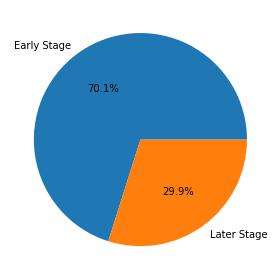

In [78]:
temp = []
for i in tab.columns: 
    s = tab[i].iloc[1]*100 / (tab[i].iloc[0] + tab[i].iloc[1])
    temp.append(s)

labels = ['Early Stage', 'Later Stage']
plt.pie(x = temp, labels = labels, autopct='%1.1f%%')

In [79]:
stats.chi2_contingency(tab) # test of association

(5412.435006607813,
 0.0,
 1,
 array([[ 2330.11489526,  8065.88510474],
        [ 2901.88510474, 10045.11489526]]))

In [80]:
cat = df['core product segment']
won = df['opportunity status'].apply(lambda x : True if x == 1 else False )
tab = pd.crosstab(won,cat)
tab

core product segment,2,3,4,5,6,7,8,9,11
opportunity status,,,,,,,,,
False,12,11914,479,276,51,40,151,20,4
True,6,9999,203,81,18,0,86,0,3


Text(0, 0.5, 'Win %')

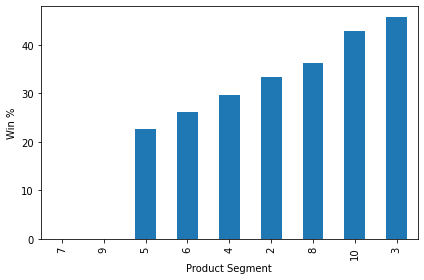

In [85]:
temp = []
for i in tab.columns: 
    s = tab[i].iloc[1]*100 / (tab[i].iloc[0] + tab[i].iloc[1])
    temp.append(s)
df = pd.Series(temp, index =  np.arange(2,11)).sort_values()
ax= df.plot.bar()
ax.set_xlabel("Product Segment")
ax.set_ylabel('Win %')

In [86]:
stats.chi2_contingency(tab)

(204.9802999139624,
 5.69851423754374e-40,
 8,
 array([[9.98354967e+00, 1.21538624e+04, 3.78265604e+02, 1.98007069e+02,
         3.82702737e+01, 2.21856659e+01, 1.31450071e+02, 1.10928330e+01,
         3.88249154e+00],
        [8.01645033e+00, 9.75913756e+03, 3.03734396e+02, 1.58992931e+02,
         3.07297263e+01, 1.78143341e+01, 1.05549929e+02, 8.90716703e+00,
         3.11750846e+00]]))

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23343 entries, 0 to 23342
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   opportunity id              23343 non-null  int64  
 1   transition to stage         23343 non-null  int64  
 2   transition to timestamp     23343 non-null  object 
 3   transition from stage name  23343 non-null  int64  
 4   transition from timestamp   23343 non-null  object 
 5   customer name               23343 non-null  int64  
 6   risk status                 23343 non-null  int64  
 7   creation date               23343 non-null  object 
 8   decision date               23343 non-null  object 
 9   opportunity status          23343 non-null  int64  
 10  opportunity type            23343 non-null  int64  
 11  core consumption market     23343 non-null  int64  
 12  core product segment        23343 non-null  int64  
 13  core sales segment          233

In [105]:
data['creation date'] = pd.to_datetime(data['creation date'], format = '%d-%m-%Y')
data['decision date'] = pd.to_datetime(data['decision date'], format = '%d-%m-%Y')
data['days'] = (data['decision date'] - data['creation date']).dt.days

In [106]:
data.columns

Index(['opportunity id', 'transition to stage', 'transition to timestamp',
       'transition from stage name', 'transition from timestamp',
       'customer name', 'risk status', 'creation date', 'decision date',
       'opportunity status', 'opportunity type', 'core consumption market',
       'core product segment', 'core sales segment', 'geography',
       'core product application', 'time taken for transition', 'product id',
       'product status', 'product $', 'product quantity', 'snapshot time',
       'cost_per_unit', 'days'],
      dtype='object')

In [107]:
data.drop(['opportunity id', 'transition to timestamp', 'transition from timestamp','creation date', 'decision date', 'customer name','snapshot time', 'product id'], axis =1, inplace = True)

In [108]:
data

,transition to stage,transition from stage name,risk status,opportunity status,opportunity type,core consumption market,core product segment,core sales segment,geography,core product application,time taken for transition,product status,product $,product quantity,cost_per_unit,days
0,3,3,0,0,0,11,3,8,-1,4,0.0,1,230400.0,1200.0,192.0,29
1,4,3,0,1,0,11,3,8,-1,4,11919999.0,1,230400.0,1200.0,192.0,29
2,4,4,0,1,0,11,3,8,1,4,1000000.0,1,230400.0,1200.0,192.0,29
3,4,4,0,1,0,11,3,8,3,4,6080000.0,1,230400.0,1200.0,192.0,29
4,4,4,0,1,1,11,3,8,3,4,92133754.0,1,230400.0,1200.0,192.0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23338,1,6,0,0,2,16,5,4,2,5,2138660.0,1,6000.0,1000.0,6.0,291
23339,1,1,0,0,2,16,5,4,2,5,2919999.0,1,60000.0,10000.0,6.0,291
23340,1,1,0,0,2,16,5,4,2,5,2919999.0,1,6000.0,1000.0,6.0,291
23341,1,1,1,0,2,16,5,4,2,5,76000001.0,1,60000.0,10000.0,6.0,291


## Univariate analysis

In [109]:
univariate_plot = ta_analysis.get_density_plots(data, cols=['transition to stage','transition from stage name','opportunity status',
 'risk status','opportunity type','core consumption market','core product segment','core sales segment','geography',
 'core product application', 'time taken for transition', 'product status', 'product $',
 'product quantity', 'days'])
# save the plots are html
create_report({'univariate': univariate_plot}, name='feature_analysis_univariate')
univariate_plot

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [days]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

## Bivariate analysis

In [110]:
binary_num_columns = [x for x in data.columns if data[x].dropna().nunique()<=2]
corr_table = ta_analysis.get_correlation_table(data[list(set(data.columns).difference(set(binary_num_columns)))])
corr_table_drop = corr_table[corr_table["Abs Corr Coef"] > 0.6]
display_as_tabs([('combinations with > 0.6 correlation', corr_table_drop.head()),('number of combinations', len(corr_table_drop)), 
('percentage of combinations', len(corr_table_drop)*100/len(corr_table))])

Tabs
    [0] DataFrame(height=300, name='combinations w..., sizing_mode='fixed', value=Empty DataFrame
Columns: [..., width=800)
    [1] Str(int, name='number of combinations')
    [2] Str(float, name='percentage of c...)

In [111]:
curated_columns = list(set(data.columns))

# create reports as needed for all the column combinations other than binary columns
all_plots = dict()
select_cols_for_bivariate_plots = list(set(curated_columns).difference(binary_num_columns))
for i, col1 in enumerate(select_cols_for_bivariate_plots): 
    for j in range(i+1, len(select_cols_for_bivariate_plots)):
        col2 = select_cols_for_bivariate_plots[j]
        out = ta_analysis.get_bivariate_plots(data, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

create_report(all_plots, name='feature_analysis_bivariate')
target_corr = ta_analysis.get_target_correlation(data[list(set(curated_columns).difference(binary_num_columns))], data['opportunity status'])
display_as_tabs([(k, v) for k,v in target_corr.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')
    [1] HoloViews(Bars, name='mutual_information')

## Test Train Split.

In [112]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    data.drop('opportunity status',axis=1), data[['opportunity status']], test_size=0.2, random_state=context.random_seed)

train_X = train_X.reset_index()
train_y = train_y.reset_index()
test_X = test_X.reset_index()
test_y = test_y.reset_index()

print(f"Saving training datasets")
dataset.save_dataset(context, train_X, 'train/features')
dataset.save_dataset(context, train_y, 'train/target')

print(f"Saving test datasets")
dataset.save_dataset(context, test_X, 'test/features')
dataset.save_dataset(context, test_y, 'test/target')

Saving training datasets
Saving test datasets
